In [ ]:
#1. Generate Dataset.
#2. Train the classifier and save it.
#3. Detect the face and named it if it is already stored in our datasets.

# Generate dataset

In [ ]:
import cv2
import os

def generate_dataset(user_id=1, emotion="neutral"):
    # Load Haarcascade Classifier
    cascade_path = "haarcascade_frontalface_default.xml"
    
    if not os.path.exists(cascade_path):
        print(f"Error: {cascade_path} not found! Please download it from OpenCV and place it in the script directory.")
        return
    
    face_classifier = cv2.CascadeClassifier(cascade_path)

    if face_classifier.empty():
        print("Error: Failed to load the face classifier.")
        return

    def face_cropped(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            return None

        for (x, y, w, h) in faces:
            return img[y:y+h, x:x+w]

    cap = cv2.VideoCapture(0)
    img_id = 0

    save_path = f"images/train/{emotion}/"
    os.makedirs(save_path, exist_ok=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image. Check your camera connection.")
            break

        cropped_face = face_cropped(frame)
        if cropped_face is not None:
            img_id += 1
            face = cv2.resize(cropped_face, (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

            file_name_path = f"{save_path}user.{user_id}.{img_id}.jpg"
            cv2.imwrite(file_name_path, face)

            cv2.putText(face, str(img_id), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow("Cropped face", face)

        if cv2.waitKey(1) == 13 or img_id == 200:
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f"Dataset for {emotion} saved in {save_path}")

# Example Usage
generate_dataset(user_id=1, emotion="happy")


# Train the classifier and save it

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

def train_classifier(train_dir):
    path = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]  # Get file paths
    faces = []
    ids = []

    for image_path in path:  # Ensure iteration is over file paths
        img = Image.open(image_path).convert('L')  # Open the image in grayscale
        imageNp = np.array(img, 'uint8')
        id = int(os.path.split(image_path)[1].split(".")[0])  # Extract ID from filename

        faces.append(imageNp)
        ids.append(id)

    ids = np.array(ids)
    clf = cv2.face.LBPHFaceRecognizer_create()
    clf.train(faces, ids)
    clf.write("classifier.xml")

# Call function with correct directory
train_classifier("images/train/angry")  # Ensure this is the actual folder containing images



# Detect the face and named it if it is already stored in our datasets.

In [1]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [2]:
TRAIN_DIR = 'images/train'
VALIDATION_DIR = 'images/validation'

In [3]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, imagename))
            labels.append(label)
        print(label,"Completed")
    return image_paths,labels

In [4]:
train = pd.DataFrame()
train['Image'], train['label'] = createdataframe(TRAIN_DIR)

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


In [5]:
print(train)

                               Image     label
0       images/train\angry\35423.jpg     angry
1       images/train\angry\35434.jpg     angry
2       images/train\angry\35483.jpg     angry
3       images/train\angry\35485.jpg     angry
4       images/train\angry\35488.jpg     angry
..                               ...       ...
422  images/train\surprise\35831.jpg  surprise
423  images/train\surprise\35842.jpg  surprise
424  images/train\surprise\35863.jpg  surprise
425  images/train\surprise\35874.jpg  surprise
426  images/train\surprise\35875.jpg  surprise

[427 rows x 2 columns]


In [6]:
validation = pd.DataFrame()
validation['Image'], validation['label'] = createdataframe(VALIDATION_DIR)



angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


In [7]:
print(validation)

                                    Image     label
0       images/validation\angry\35423.jpg     angry
1       images/validation\angry\35434.jpg     angry
2       images/validation\angry\35483.jpg     angry
3       images/validation\angry\35485.jpg     angry
4       images/validation\angry\35488.jpg     angry
..                                    ...       ...
422  images/validation\surprise\35831.jpg  surprise
423  images/validation\surprise\35842.jpg  surprise
424  images/validation\surprise\35863.jpg  surprise
425  images/validation\surprise\35874.jpg  surprise
426  images/validation\surprise\35875.jpg  surprise

[427 rows x 2 columns]


In [8]:
from tqdm.notebook import tqdm

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale= True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [10]:
train_features = extract_features(train['Image'])

  0%|          | 0/427 [00:00<?, ?it/s]

c:\Users\rajsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [11]:
validation_features = extract_features(validation['Image'])


  0%|          | 0/427 [00:00<?, ?it/s]

In [12]:
x_train = train_features/255.0
x_validation = validation_features/255.0

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [15]:
y_train = le.transform(train['label'])
y_validation = le.transform(validation['label'])

In [16]:
y_train = to_categorical(y_train, num_classes= 7)
y_validation = to_categorical(y_validation, num_classes= 7)

In [17]:
from tensorflow.keras.layers import Dropout


model = Sequential()

# Convolutional Layers

model.add(Conv2D(128, kernel_size= (3,3),activation='relu', input_shape = (48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size= (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size= (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size= (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
# output Layer
model.add(Dense(7, activation='softmax'))


c:\Users\rajsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
model.fit(x = x_train, y= y_train, batch_size= 128, epochs= 100, validation_data= (x_validation,y_validation))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 794ms/step - accuracy: 0.1756 - loss: 1.9578 - val_accuracy: 0.2389 - val_loss: 1.9409
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - accuracy: 0.2095 - loss: 1.9362 - val_accuracy: 0.2389 - val_loss: 1.9373
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step - accuracy: 0.2474 - loss: 1.9243 - val_accuracy: 0.2389 - val_loss: 1.9332
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - accuracy: 0.2442 - loss: 1.9230 - val_accuracy: 0.2389 - val_loss: 1.9295
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step - accuracy: 0.2497 - loss: 1.9159 - val_accuracy: 0.2389 - val_loss: 1.9285
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - accuracy: 0.2500 - loss: 1.9184 - val_accuracy: 0.2389 - val_loss: 1.9269
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - accuracy: 0.2419 - loss: 1.9168 - val_accuracy: 0.2389 - val_loss: 1.9226
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 0.2354 - loss: 1.9242 - val_accuracy: 0.2389 - v

In [20]:
model_json = model.to_json()
with open("faceemotiondetection.json",'w') as json_file:
    json_file.write(model_json)
    model.save("faceemotiondetection.h5")

In [21]:
from keras.models import model_from_json

In [22]:
json_file = open("faceemotiondetection.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("faceemotiondetection.h5")

In [23]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [24]:
def ef(image):
    img = load_img(image, grayscale = True)
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [25]:
image = 'images/train/sad/33936.jpg'
print("Original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is",pred_label)

Original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


c:\Users\rajsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


model prediction is sad


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt


Original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
model prediction is sad


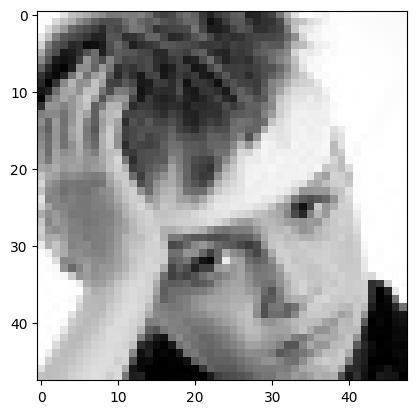

In [27]:
image = 'images/train/sad/34413.jpg'
print("Original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is",pred_label)
plt.imshow(img.reshape(48,48),cmap = 'gray')

Original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
model prediction is fear


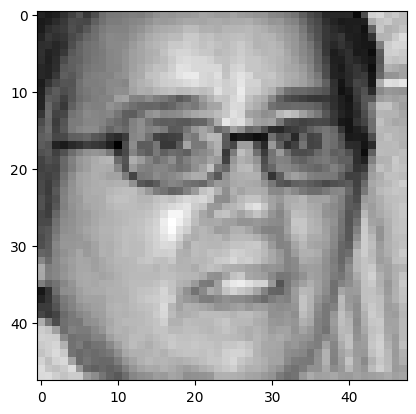

In [28]:
image = 'images/train/fear/35467.jpg'
print("Original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is",pred_label)
plt.imshow(img.reshape(48,48),cmap = 'gray')

Original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
model prediction is disgust


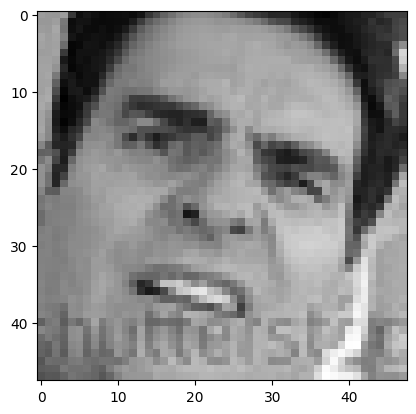

In [29]:
image = 'images/train/disgust/31322.jpg'
print("Original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is",pred_label)
plt.imshow(img.reshape(48,48),cmap = 'gray')

In [ ]:
import cv2
from keras.models import model_from_json
import numpy as np

# from keras_preprocessing_image import load_img

json_file = open("faceemotiondetection.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.load_weights("faceemotiondetection.h5")
haar_file = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_file)  


def extract_features(image):
    features = np.array(image)
    features = features.reshape(1,48,48,1)
    return features/255.0

webcam = cv2.VideoCapture(0)
labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
while True:
    i,im = webcam.read()
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    try:
        for(p,q,r,s) in faces:
            image = gray[q: q+s, p: p+r]
            cv2.rectangle(im,(p,q),(p+r,q+s),(255,0,0),2)
            image = cv2.resize(image,(48,48))
            img = extract_features(image)
            pred = model.predict(img)
            prediction_label = labels[pred.argmax()]
                
                # print("predicted output:",prediction_label)
                # cv2.putText(im,prediction_label)
            cv2.putText(im, '% s' %(prediction_label),(p-10,q-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,(0,0,255))
        cv2.imshow("output",im)
        cv2.waitKey(27)
    except cv2.error:
        pass
cap.release()    
webcam.release()
cv2.destroyAllWindows()

Facial Emotion UI